## 데이터 로드

In [2]:
# 필수 라이브러리 Import
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.preprocessing import LabelEncoder

# 부스팅 모델
from catboost import CatBoostClassifier
import lightgbm as lgb

from tqdm import tqdm

In [3]:
# 데이터 로드
all_train = pd.read_parquet("train.parquet", engine="pyarrow")
test = pd.read_parquet("test.parquet", engine="pyarrow").drop(columns=['ID'])

print("Train shape:", all_train.shape)
print("Test shape:", test.shape)

Train shape: (10704179, 119)
Test shape: (1527298, 118)


In [6]:
import pandas as pd

# 컬럼 전부 출력 (생략 없음)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)  # 한 줄로 펼치지 않게
pd.set_option("display.max_colwidth", None)        # 컬럼 내용 생략 없이

print(all_train.isnull().sum().to_string())

gender            17208
age_group         17208
inventory_id          0
day_of_week           0
hour                  0
seq                   0
l_feat_1              0
l_feat_2          17208
l_feat_3              0
l_feat_4              0
l_feat_5              0
l_feat_6              0
l_feat_7              0
l_feat_8          17208
l_feat_9              0
l_feat_10             0
l_feat_11             0
l_feat_12             0
l_feat_13             0
l_feat_14             0
l_feat_15             0
l_feat_16             0
l_feat_17             0
l_feat_18         17208
l_feat_19         17208
l_feat_20         17208
l_feat_21         17208
l_feat_22         17208
l_feat_23         17208
l_feat_24         17208
l_feat_25             0
l_feat_26             0
l_feat_27             0
feat_e_1          17208
feat_e_2          17208
feat_e_3        1085557
feat_e_4          17208
feat_e_5          17208
feat_e_6          17208
feat_e_7          17208
feat_e_8          17208
feat_e_9        

In [3]:
all_train.head()

,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1.0,7.0,36,5,13,"9,18,269,516,57,97,527,74,317,311,269,479,57,7...",1.0,2.0,1.0,23.0,...,0.070092,0.070092,0.011682,0.004673,0.087226,0.049843,0.015576,0.040498,0.051401,0
1,1.0,7.0,2,5,08,"9,144,269,57,516,97,527,74,315,317,311,269,479...",2.0,2.0,3.0,17.0,...,0.072990,0.072990,0.012165,0.004866,0.045416,0.051904,0.016220,0.042172,0.026763,0
2,1.0,7.0,36,5,11,"269,516,57,97,165,527,74,77,317,269,75,450,15,...",1.0,2.0,1.0,7.0,...,0.057177,0.057177,0.009530,0.003812,0.035577,0.081318,0.012706,0.033036,0.062898,0
3,1.0,8.0,37,5,11,"269,57,516,21,214,269,561,214,269,561,247,516,...",2.0,2.0,2.0,7.0,...,0.100449,0.100449,0.016741,0.006697,0.062502,0.071430,0.022322,0.058037,0.073659,0
4,2.0,7.0,37,5,07,"144,269,57,516,35,479,57,516,527,74,77,318,193...",2.0,2.0,3.0,24.0,...,0.064512,0.064512,0.010752,0.004301,0.040141,0.045875,0.014336,0.037274,0.023654,0


# 간단한 EDA
- 주최측에서 변수의 정보를 비공개하려는 의사가 매우강하여 제한적으로 추측할수밖에 없음

## 성별에 따른 클릭빈도
- 과거 토스앱 통계에 따르면 남녀 비율이 현재 데이터셋 비율과 크게 다르지않은것을 보여줌
- 과거 통계를 기반으로 생각한다면 1은 남자, 2는 여자로 판단  
(https://brunch.co.kr/@mobiinside/1463)

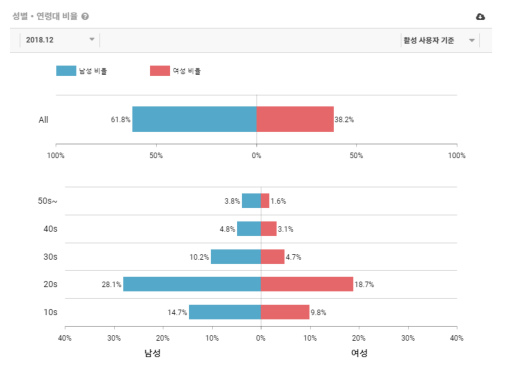

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread("1757583211040168.png")  # imread 사용!
plt.imshow(img1)
plt.axis('off')
plt.show()

In [9]:
all_train['gender'].value_counts()

gender
1.0    6713514
2.0    3973457
Name: count, dtype: int64

## 요일별 클릭 빈도
- day_of_week의 범위가 1~7로 들어간걸로 봤을 때 주말은 6,7로 볼 수 있음
- 하지만 요일에 상관없이 클릭빈도가 그렇게 차이가 나는건 아님

In [10]:
all_train['day_of_week'].value_counts()

day_of_week
2    1532022
4    1530297
6    1530282
3    1529921
5    1529839
7    1526335
1    1525483
Name: count, dtype: int64

## 광고를 클릭하는 연령층  
- 보통 앱을 많이 사용하는 연령층은 젊은층이 많다고 판단됨  
- 따라서 8.0>10대, 7.0>20대와 같이 역순으로 볼수있음

In [11]:
all_train['age_group'].value_counts().sort_index(ascending=False)

age_group
8.0    2646736
7.0    3706802
6.0    2320895
5.0     591501
4.0     554070
3.0     479087
2.0     358917
1.0      28963
Name: count, dtype: int64

## 광고클릭 시간대
- 상식선에서 광고클릭의 빈도가 높은 시간대와 낮은 시간대를 추측하여 시간대를 자정(0시), 새벽(1시~5시), 아침(6시~12시), 오후(13시~15시), 저녁(16시~21시), 심야(22시~23시) 으로 구분하였음

In [ ]:
all_train['hour'].value_counts()

hour
08    755311
12    607775
07    603023
09    587434
20    584545
10    576432
19    569826
21    541590
00    536658
11    512721
13    502610
18    493294
22    480611
06    477708
17    448382
14    439980
16    421292
15    417579
23    413938
05    273189
01    172955
04    110006
02     98671
03     78649
Name: count, dtype: int64

: 

## 피쳐엔지니어링
- 시퀀스피쳐 처리할 때 시간이 너무 오래걸려서 파생변수 생성 후 모델이 학습하기 최적화되도록 데이터셋 정제

In [ ]:
# -*- coding: utf-8 -*-
# =========================================================
# CTR 예측 — pre-TE 즉시 캐시 + 안전한 KFold TargetEncoding
# (요청 반영)
#   ✅ 메인 교차: gender × age_group × inventory_id × hour_bucket → TE 적용
#   ✅ 보조 교차: dow_hour → freq/rank만
#   ✅ 시계열: hour_sin/hour_cos 추가
# =========================================================

import os, gc, random, warnings, pickle, time
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

# ------------------------------
# 설정
# ------------------------------
CFG = {
    'SEED': 42,
    'N_FOLDS': 5,
    'DOWNSAMPLE_RATIO': 2,    # clicked=1 대비 0의 배수 (2=1:2)
}

random.seed(CFG['SEED'])
np.random.seed(CFG['SEED'])
os.environ['PYTHONHASHSEED'] = str(CFG['SEED'])

# 경로
TRAIN_PATH = "train.parquet"
TEST_PATH  = "test.parquet"
SAMPLE_SUB_CANDIDATES = ["./sample_submission.csv",
                         "/content/drive/MyDrive/open/sample_submission.csv"]

OUT_DIR = "outputs_test"
PRETE_DIR = os.path.join(OUT_DIR, "cache_preTE")
FEATURE_DIR = os.path.join(OUT_DIR, "features_postTE")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PRETE_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)

TR_PRE = os.path.join(PRETE_DIR, "train_preTE.pkl")
TE_PRE = os.path.join(PRETE_DIR, "test_preTE.pkl")

TR_POST = os.path.join(FEATURE_DIR, "train_features.pkl")
TE_POST = os.path.join(FEATURE_DIR, "test_features.pkl")

target_col = "clicked"
seq_col = "seq"

# 유틸
def tic(): return time.time()
def toc(t0, msg=""): print(f"⏱️  {msg} | {time.time()-t0:.1f}s")

def _atomic_dump_pkl(obj, path):
    tmp = path + ".tmp"
    with open(tmp, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    os.replace(tmp, path)

def _backup_if_exists(path):
    if os.path.exists(path):
        ts = time.strftime("%Y%m%d_%H%M%S")
        bak = f"{path}.bak_{ts}"
        import shutil; shutil.copy2(path, bak)
        return bak
    return None

def _save_all_formats(df: pd.DataFrame, csv_path: str, pq_path: str, fe_path: str):
    df.to_csv(csv_path, index=False)
    try: df.to_parquet(pq_path, index=False)
    except Exception: pass
    try: df.reset_index(drop=True).to_feather(fe_path)
    except Exception: pass

# ------------------------------
# 시퀀스 피처
# ------------------------------
def seq_extra_features(seq_vals: np.ndarray):
    out = {}
    L = len(seq_vals)
    if L == 0:
        out.update({'seq_ewma_mean':0,'seq_ewma_std':0,'seq_last3_mean':0,'seq_last5_mean':0,
                    'seq_pos_rate':0,'seq_neg_rate':0,'seq_nonzero_rate':0,'seq_sign_changes':0,
                    'seq_peaks':0,'seq_acf1':0,'seq_q90_q10_ratio':0})
        return out
    alpha = 0.3
    w = (1-alpha) ** np.arange(L-1, -1, -1, dtype='float32'); w /= w.sum()
    ewma_mean = float(np.sum(seq_vals * w))
    ewma_std  = float(np.sqrt(np.sum(((seq_vals - ewma_mean)**2) * w)))
    last3_mean = float(np.mean(seq_vals[-3:])) if L>=3 else float(np.mean(seq_vals))
    last5_mean = float(np.mean(seq_vals[-5:])) if L>=5 else float(np.mean(seq_vals))
    pos_rate = float(np.mean(seq_vals>0))
    neg_rate = float(np.mean(seq_vals<0))
    nonzero_rate = float(np.mean(seq_vals!=0))
    signs = np.sign(seq_vals)
    sign_changes = int(np.sum(signs[1:] != signs[:-1]))
    peaks = int(np.sum((seq_vals[1:-1] > seq_vals[:-2]) & (seq_vals[1:-1] > seq_vals[2:]))) if L>=3 else 0
    acf1 = float(np.corrcoef(seq_vals[:-1], seq_vals[1:])[0,1]) if (L>=2 and np.std(seq_vals)>0) else 0.0
    q90 = np.percentile(seq_vals, 90); q10 = np.percentile(seq_vals, 10)
    q_ratio = float(q90 / q10) if q10 != 0 else 0.0
    out.update({'seq_ewma_mean': ewma_mean, 'seq_ewma_std': ewma_std,
                'seq_last3_mean': last3_mean, 'seq_last5_mean': last5_mean,
                'seq_pos_rate': pos_rate, 'seq_neg_rate': neg_rate, 'seq_nonzero_rate': nonzero_rate,
                'seq_sign_changes': sign_changes, 'seq_peaks': peaks, 'seq_acf1': acf1,
                'seq_q90_q10_ratio': q_ratio})
    return out

def extract_sequence_features(seq_obj):
    feats = {'seq_length':0,'seq_mean':0,'seq_std':0,'seq_min':0,'seq_max':0,'seq_sum':0,
             'seq_median':0,'seq_q25':0,'seq_q75':0,'seq_unique_count':0,'seq_first':0,'seq_last':0,
             'seq_first_last_diff':0,'seq_trend':0,'seq_zero_count':0,'seq_positive_count':0,
             'seq_negative_count':0,'seq_max_consecutive_zeros':0,'seq_skewness':0,'seq_kurtosis':0,
             'seq_unique_ratio':0,'seq_range':0,'seq_iqr':0,'seq_mean_diff':0,'seq_last_diff':0}
    try:
        if isinstance(seq_obj, str): seq_values = np.fromstring(seq_obj, sep=',', dtype=np.float32)
        else: seq_values = np.asarray(seq_obj, dtype=np.float32)
        if seq_values.size == 0: return feats
        L = len(seq_values)
        feats.update({
            'seq_length': L,
            'seq_mean': float(np.mean(seq_values)),
            'seq_std': float(np.std(seq_values)) if L>1 else 0.0,
            'seq_min': float(np.min(seq_values)),
            'seq_max': float(np.max(seq_values)),
            'seq_sum': float(np.sum(seq_values)),
            'seq_median': float(np.median(seq_values)),
            'seq_q25': float(np.percentile(seq_values, 25)),
            'seq_q75': float(np.percentile(seq_values, 75)),
            'seq_unique_count': int(np.unique(seq_values).size),
            'seq_first': float(seq_values[0]),
            'seq_last': float(seq_values[-1]),
            'seq_first_last_diff': float(seq_values[-1] - seq_values[0]),
            'seq_zero_count': int(np.sum(seq_values==0)),
            'seq_positive_count': int(np.sum(seq_values>0)),
            'seq_negative_count': int(np.sum(seq_values<0)),
        })
        # 최대 연속 0
        zero_groups, z = [], 0
        for v in seq_values:
            if v==0: z+=1
            else:
                if z>0: zero_groups.append(z); z=0
        if z>0: zero_groups.append(z)
        feats['seq_max_consecutive_zeros'] = max(zero_groups) if zero_groups else 0
        # 트렌드
        if L>1 and np.std(seq_values)>0:
            x = np.arange(L, dtype=np.float32)
            feats['seq_trend'] = float(np.corrcoef(x, seq_values)[0,1])
        # 왜도/첨도
        try:
            from scipy.stats import skew, kurtosis
            if L>2 and np.std(seq_values)>0:
                feats['seq_skewness'] = float(skew(seq_values))
                feats['seq_kurtosis'] = float(kurtosis(seq_values))
        except: pass
        feats['seq_unique_ratio'] = float(feats['seq_unique_count']/L)
        feats['seq_range']  = float(feats['seq_max'] - feats['seq_min'])
        feats['seq_iqr']    = float(feats['seq_q75'] - feats['seq_q25'])
        feats['seq_mean_diff'] = float(feats['seq_first'] - feats['seq_mean'])
        feats['seq_last_diff'] = float(feats['last'] - feats['seq_mean']) if 'last' in feats else 0.0
        feats.update(seq_extra_features(seq_values))
        return feats
    except Exception:
        return feats

def build_seq_features(df: pd.DataFrame, seq_col: str) -> pd.DataFrame:
    rows = []
    print(f"   - sequence rows: {len(df)}")
    for s in tqdm(df[seq_col].astype(str), desc="   Extract seq feats", miniters=1000):
        rows.append(extract_sequence_features(s))
    seq_df = pd.DataFrame(rows)
    for c in seq_df.columns:
        if str(seq_df[c].dtype).startswith('float'):
            seq_df[c] = pd.to_numeric(seq_df[c], downcast='float')
        elif str(seq_df[c].dtype).startswith('int'):
            seq_df[c] = pd.to_numeric(seq_df[c], downcast='integer')
    return seq_df

def ensure_seq_cache(train_df, test_df, seq_col, tr_path, te_path, csv_te, pq_te, fe_te, csv_tr, pq_tr, fe_tr):
    need = (not os.path.exists(tr_path)) or (not os.path.exists(te_path))
    if need:
        print("▶ Sequence features … compute & SAVE")
        tr_seq = build_seq_features(train_df, seq_col)
        te_seq = build_seq_features(test_df, seq_col)
        _backup_if_exists(tr_path); _backup_if_exists(te_path)
        _atomic_dump_pkl(tr_seq, tr_path)
        _atomic_dump_pkl(te_seq, te_path)
        _save_all_formats(tr_seq, csv_tr, pq_tr, fe_tr)
        _save_all_formats(te_seq, csv_te, pq_te, fe_te)
        print(f"   saved: {tr_path}, {te_path} (+csv/parquet/feather)")
        return tr_seq, te_seq

    print("▶ Sequence features … load cache")
    with open(tr_path, "rb") as f: tr_seq = pickle.load(f)
    with open(te_path, "rb") as f: te_seq = pickle.load(f)
    return tr_seq, te_seq

# ------------------------------
# 시간 파생 (요청 반영)
# ------------------------------
def add_time_derivatives_custom(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # is_weekend
    if 'day_of_week' in out.columns:
        dow = pd.to_numeric(out['day_of_week'], errors='coerce')
        out['is_weekend'] = dow.isin([6,7]).astype('int8')

    if 'hour' in out.columns:
        hour = pd.to_numeric(out['hour'], errors='coerce')
        bins   = [-0.5, 0.5, 5.5, 12.5, 17.5, 21.5, 23.5]
        labels = ['night0','late','morning','afternoon','evening','night22_23']
        out['hour_bucket'] = pd.cut(hour, bins=bins, labels=labels,
                                    include_lowest=True, ordered=False).astype('category')
        out['hour_bucket_simple'] = out['hour_bucket'].astype(str).replace(
            {'night0':'night', 'night22_23':'night'}
        ).astype('category')
        out['_hour_int_'] = hour.fillna(-1).astype('int16')

        # 시계열 주기성 (24h)
        hour_norm = 2 * np.pi * hour.fillna(0) / 24.0
        out['hour_sin'] = np.sin(hour_norm).astype('float32')
        out['hour_cos'] = np.cos(hour_norm).astype('float32')

    # dow_hour (보조: freq/rank만 적용 예정)
    if 'day_of_week' in out.columns and 'hour' in out.columns:
        dow_i = pd.to_numeric(out['day_of_week'], errors='coerce').fillna(-1).astype('int8')
        out['dow_hour'] = (dow_i.astype(str) + '|' + out['_hour_int_'].astype(str)).astype('category')

    out.drop(columns=['_hour_int_'], inplace=True, errors='ignore')
    return out

# ------------------------------
# 교차/빈도
# ------------------------------
def cross_cat(df: pd.DataFrame, pairs):
    for a, b in pairs:
        if a in df.columns and b in df.columns:
            name = f'{a}__{b}'
            df[name] = (df[a].astype(str) + '|' + df[b].astype(str)).astype('category')
    return df

def cross_main(df: pd.DataFrame):
    # 메인 교차: gender × age_group × inventory_id × hour_bucket
    need = {'gender','age_group','inventory_id','hour_bucket'}
    if need.issubset(df.columns):
        df['gender_age_inventory_hour'] = (
            df['gender'].astype(str) + '|' +
            df['age_group'].astype(str) + '|' +
            df['inventory_id'].astype(str) + '|' +
            df['hour_bucket'].astype(str)
        ).astype('category')
    return df

def add_freq_rank(train_df, test_df, cols):
    exist_cols = [c for c in cols if c in train_df.columns]
    for c in tqdm(exist_cols, desc="   Freq/Rank encoding (safe)"):
        # 1) 카테고리/오브젝트 섞임 방지: 모두 문자열로 통일
        trc = train_df[c].astype(str)
        tec = test_df[c].astype(str) if c in test_df.columns else pd.Series(["__NA__"]*len(test_df), index=test_df.index)

        # 2) 빈도(count) 기반 매핑 (train 분포 사용)
        vc = trc.value_counts()

        train_df[f'freq_{c}']  = trc.map(vc).fillna(0).astype('int32')
        test_df[f'freq_{c}']   = tec.map(vc).fillna(0).astype('int32')

        # 3) 랭크(빈도 내림차순)
        rank = vc.rank(ascending=False, method='average')
        max_rank = float(rank.max()) if len(rank) > 0 else 0.0

        train_df[f'frank_{c}'] = trc.map(rank).fillna(max_rank + 1).astype('float32')
        test_df[f'frank_{c}']  = tec.map(rank).fillna(max_rank + 1).astype('float32')

    return train_df, test_df

# ------------------------------
# 안전한 KFold Target Encoding (float 새 컬럼으로만)
# ------------------------------
def kfold_target_encoding_safe(train_df, test_df, col, target='clicked', n_splits=5, seed=42, smoothing=50):
    tr_col = train_df[col].astype(str)
    te_col = test_df[col].astype(str)
    y = train_df[target].values
    global_mean = float(np.mean(y))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(train_df), dtype='float32')

    for tr_idx, va_idx in skf.split(tr_col.values.reshape(-1,1), y):
        fold_tr = tr_col.iloc[tr_idx]
        fold_y  = y[tr_idx]
        fold_va = tr_col.iloc[va_idx]

        stats = (
            pd.DataFrame({'key': fold_tr.values, 'y': fold_y})
              .groupby('key')['y'].agg(['mean','count'])
        )
        stats['te'] = (stats['mean']*stats['count'] + global_mean*smoothing) / (stats['count'] + smoothing)
        oof[va_idx] = fold_va.map(stats['te']).fillna(global_mean).astype('float32').values

    stats_full = (
        pd.DataFrame({'key': tr_col.values, 'y': y})
          .groupby('key')['y'].agg(['mean','count'])
    )
    stats_full['te'] = (stats_full['mean']*stats_full['count'] + global_mean*smoothing) / (stats_full['count'] + smoothing)
    te_enc = te_col.map(stats_full['te']).fillna(global_mean).astype('float32').values

    return pd.Series(oof, index=train_df.index), pd.Series(te_enc, index=test_df.index)

def apply_te_block_safe(train_df, test_df, cols, target='clicked', prefix='te_'):
    for c in tqdm([x for x in cols if x in train_df.columns], desc="   Target Encoding (safe)"):
        tr_enc, te_enc = kfold_target_encoding_safe(
            train_df, test_df, c, target,
            n_splits=CFG['N_FOLDS'], seed=CFG['SEED']
        )
        train_df[f"{prefix}{c}"] = tr_enc  # float32
        test_df[f"{prefix}{c}"]  = te_enc  # float32
    return train_df, test_df

# ------------------------------
# 메트릭 (참고용)
# ------------------------------
def calculate_competition_score(y_true, y_pred_proba):
    ap = average_precision_score(y_true, y_pred_proba)
    pos = np.sum(y_true)
    neg = len(y_true) - pos
    pos_weight = len(y_true) / (2 * pos)
    neg_weight = len(y_true) / (2 * neg)
    ypp = np.clip(y_pred_proba, 1e-7, 1-1e-7)
    log_loss_pos = -np.mean(y_true * np.log(ypp)) * pos_weight
    log_loss_neg = -np.mean((1 - y_true) * np.log(1 - ypp)) * neg_weight
    wll = log_loss_pos + log_loss_neg
    final_score = 0.5 * ap + 0.5 * (1 - wll)
    return {'ap': ap, 'wll': wll, 'final_score': final_score}

# =========================================================
# 실행 영역
# =========================================================
if __name__ == "__main__":
    # ------------------------------
    # 데이터 로드 & 다운샘플
    # ------------------------------
    print("\n=== 1) Load data ===")
    t0 = tic()
    all_train = pd.read_parquet(TRAIN_PATH, engine="pyarrow")
    test_base = pd.read_parquet(TEST_PATH, engine="pyarrow")
    print(f"Base Train: {all_train.shape} | Test: {test_base.shape}")
    toc(t0, "Loaded parquet")

    print("\n=== 2) Downsample (class imbalance) ===")
    t0 = tic()
    clicked_1 = all_train[all_train[target_col] == 1]
    clicked_0 = all_train[all_train[target_col] == 0].sample(
        n=len(clicked_1) * CFG['DOWNSAMPLE_RATIO'], random_state=CFG['SEED']
    )
    train_base = pd.concat([clicked_1, clicked_0], axis=0).sample(frac=1, random_state=CFG['SEED']).reset_index(drop=True)
    del clicked_1, clicked_0; gc.collect()
    print(f"Downsampled Train: {train_base.shape} | 0:{(train_base[target_col]==0).sum()} | 1:{(train_base[target_col]==1).sum()}")
    toc(t0, "downsample done")

    # ------------------------------
    # pre-TE 빌드 (시퀀스/시간/교차/빈도·순위)
    # ------------------------------
    print("\n=== 3) Build pre-TE ===")
    t0 = tic()

    # 시퀀스 캐시 경로
    TR_SEQ_PKL = os.path.join(PRETE_DIR, "train_seq_feats.pkl")
    TE_SEQ_PKL = os.path.join(PRETE_DIR, "test_seq_feats.pkl")
    TR_SEQ_CSV = os.path.join(PRETE_DIR, "train_seq_feats.csv")
    TE_SEQ_CSV = os.path.join(PRETE_DIR, "test_seq_feats.csv")
    TR_SEQ_PQ  = os.path.join(PRETE_DIR, "train_seq_feats.parquet")
    TE_SEQ_PQ  = os.path.join(PRETE_DIR, "test_seq_feats.parquet")
    TR_SEQ_FE  = os.path.join(PRETE_DIR, "train_seq_feats.feather")
    TE_SEQ_FE  = os.path.join(PRETE_DIR, "test_seq_feats.feather")

    tr_seq, te_seq = ensure_seq_cache(
        train_base, test_base, seq_col,
        TR_SEQ_PKL, TE_SEQ_PKL,
        TE_SEQ_CSV, TE_SEQ_PQ, TE_SEQ_FE,
        TR_SEQ_CSV, TR_SEQ_PQ, TR_SEQ_FE
    )

    # 병합
    tr = pd.concat([train_base.drop(columns=[seq_col]).reset_index(drop=True), tr_seq.reset_index(drop=True)], axis=1)
    te = pd.concat([test_base.drop(columns=[seq_col]).reset_index(drop=True),  te_seq.reset_index(drop=True)], axis=1)
    del tr_seq, te_seq; gc.collect()

    # 시간 파생 (hour_bucket + hour_sin/cos + dow_hour)
    tr = add_time_derivatives_custom(tr)
    te = add_time_derivatives_custom(te)

    # 메인 교차 (gender × age × inventory × hour_bucket)
    tr = cross_main(tr)
    te = cross_main(te)

    # (선택) 보조 교차 일부 유지
    cross_pairs = [
        ('day_of_week','inventory_id'),
        ('gender','age_group'),
        ('is_weekend','hour_bucket'),
        ('hour_bucket','inventory_id'),
    ]
    tr = cross_cat(tr, cross_pairs)
    te = cross_cat(te, cross_pairs)

    # 빈도/순위 (dow_hour는 freq/rank만)
    freq_cols = [
        'ad_id','ad_group_id','campaign_id','keyword_id','inventory_id',
        'match_type','device_type','gender','age_group','dow_hour'
    ]
    tr, te = add_freq_rank(tr, te, freq_cols)

    # 다운캐스트
    for df_ in (tr, te):
        for c in df_.columns:
            if c == target_col: continue
            if str(df_[c].dtype) == 'float64':
                df_[c] = pd.to_numeric(df_[c], downcast='float')
            elif str(df_[c].dtype) == 'int64':
                df_[c] = pd.to_numeric(df_[c], downcast='integer')

    # pre-TE 캐시 저장
    _backup_if_exists(TR_PRE); _backup_if_exists(TE_PRE)
    _atomic_dump_pkl(tr, TR_PRE); _atomic_dump_pkl(te, TE_PRE)
    print(f"💾 Saved pre-TE cache → {TR_PRE} | {TE_PRE}")
    print(f"pre-TE shapes → train {tr.shape} | test {te.shape}")
    toc(t0, "pre-TE build done")

    # ------------------------------
    # 안전한 Target Encoding
    #  - 메인 교차 'gender_age_inventory_hour' 포함
    #  - 'dow_hour'는 TE 제외 (freq/rank만)
    # ------------------------------
    print("\n=== 4) Target Encoding (safe) ===")
    t0 = tic()
    te_cols = [
        'campaign_id','ad_group_id','ad_id','keyword_id','inventory_id',
        'match_type','device_type','gender','age_group','hour_bucket',
        'gender_age_inventory_hour',  # ✅ 메인 교차 TE
        # 'dow_hour'는 제외 (freq/rank만)
        'is_weekend__hour_bucket',
        'hour_bucket__inventory_id',
    ]

    train_features, test_features = tr.copy(), te.copy()
    train_features, test_features = apply_te_block_safe(
        train_features, test_features, te_cols, target=target_col, prefix='te_'
    )

    # post-TE 저장
    _backup_if_exists(TR_POST); _backup_if_exists(TE_POST)
    _atomic_dump_pkl(train_features, TR_POST)
    _atomic_dump_pkl(test_features, TE_POST)
    print(f"💾 Saved post-TE features → {TR_POST} | {TE_POST}")
    print(f"Train feats (post-TE): {train_features.shape} | Test feats (post-TE): {test_features.shape}")
    toc(t0, "TE done")

    print("\n✅ DONE: pre-TE + (요청반영) 교차/시계열 + 안전 TE 캐시 완료")


=== 1) Load data ===
Base Train: (10704179, 119) | Test: (1527298, 119)
⏱️  Loaded parquet | 72.6s

=== 2) Downsample (class imbalance) ===
Downsampled Train: (612537, 119) | 0:408358 | 1:204179
⏱️  downsample done | 9.8s

=== 3) Build pre-TE ===
▶ Sequence features … load cache


   Freq/Rank encoding (safe):   0%|          | 0/4 [00:00<?, ?it/s]

💾 Saved pre-TE cache → outputs_test/cache_preTE/train_preTE.pkl | outputs_test/cache_preTE/test_preTE.pkl
pre-TE shapes → train (612537, 173) | test (1527298, 173)
⏱️  pre-TE build done | 6.3s

=== 4) Target Encoding (safe) ===


   Target Encoding (safe):   0%|          | 0/7 [00:00<?, ?it/s]

💾 Saved post-TE features → outputs_test/features_postTE/train_features.pkl | outputs_test/features_postTE/test_features.pkl
Train feats (post-TE): (612537, 180) | Test feats (post-TE): (1527298, 180)
⏱️  TE done | 3.8s

✅ DONE: pre-TE + (요청반영) 교차/시계열 + 안전 TE 캐시 완료


: 